In [3]:
# GHSL Employment Mapping: Pixel-Level Disaggregation using Random Forest

# Step 0: Setup
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from rasterio.enums import Resampling
from shapely.geometry import Point
from pyproj import Transformer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Paths
GHSL_DIR = "C:/Users/DELL/Desktop/GHSL_ALL"  # folder with GHSL rasters
EMPLOYMENT_CSV = "D:/ERP/Data/Employment_LA.csv"
LA_CSV = "D:/ERP/Data/LA_UK.csv"

# Step 1: Load GHSL Rasters
built_files = sorted(glob.glob(os.path.join(GHSL_DIR, "*BUILT*.tif")))
pop_files = sorted(glob.glob(os.path.join(GHSL_DIR, "*POP*.tif")))
built_srcs = [rasterio.open(fp) for fp in built_files]
pop_srcs = [rasterio.open(fp) for fp in pop_files]

# Merge built
built_merged, built_transform = merge(built_srcs)
ref_profile = built_srcs[0].profile
ref_shape = built_merged.shape[1:]
ref_crs = ref_profile["crs"]

# Resample population
resampled_pop_arrays = [
    src.read(1, out_shape=(ref_shape[0], ref_shape[1]), resampling=Resampling.bilinear)
    for src in pop_srcs
]
resampled_pop_merged = np.nanmean(resampled_pop_arrays, axis=0)

# Step 2: Extract pixel features
x_coords, y_coords = rasterio.transform.xy(built_transform, *np.indices(ref_shape), offset='center')
pixel_data = pd.DataFrame({
    'x': np.array(x_coords).ravel(),
    'y': np.array(y_coords).ravel(),
    'built': built_merged[0].ravel(),
    'pop': resampled_pop_merged.ravel()
})
pixel_data = pixel_data[(pixel_data['built'] > 0) | (pixel_data['pop'] > 0)]

transformer = Transformer.from_crs(ref_crs, "EPSG:4326", always_xy=True)
pixel_data[['lon', 'lat']] = pixel_data.apply(lambda row: pd.Series(transformer.transform(row['x'], row['y'])), axis=1)
geometry = [Point(xy) for xy in zip(pixel_data['lon'], pixel_data['lat'])]
gdf_pixels = gpd.GeoDataFrame(pixel_data, geometry=geometry, crs="EPSG:4326")

# Step 3: Load LA and Employment Data
df_employment = pd.read_csv(EMPLOYMENT_CSV)
df_la_attr = pd.read_csv(LA_CSV)
df_employment = df_employment.rename(columns={
    "Local Authority District": "LAD25NM",
    "Total employment (all)": "Employment_2023_Thousands"
})
df_merged = df_la_attr.merge(df_employment, on="LAD25NM", how="left")
gdf_la_points = gpd.GeoDataFrame(
    df_merged,
    geometry=gpd.points_from_xy(df_merged["LONG"], df_merged["LAT"]),
    crs="EPSG:4326"
)
gdf_la_polygons = gdf_la_points.copy()
gdf_la_polygons['geometry'] = gdf_la_polygons.geometry.buffer(0.2)

# Step 4: Spatial Join to Assign Employment Density
gdf_joined = gpd.sjoin(
    gdf_pixels,
    gdf_la_polygons[["LAD25NM", "Employment_2023_Thousands", "geometry"]],
    how="inner",
    predicate='within'
)
gdf_joined["employment_density_target"] = gdf_joined["Employment_2023_Thousands"] * 1000 / gdf_joined.groupby("LAD25NM")["LAD25NM"].transform("count")

C:\Users\DELL\AppData\Local\Temp\ipykernel_19412\1305662308.py:70: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_la_polygons['geometry'] = gdf_la_polygons.geometry.buffer(0.2)


In [4]:
# Step 5: Train Random Forest
from sklearn.ensemble import RandomForestRegressor

# 1. Check for missing target values
print("Number of pixels with missing target:", gdf_joined['employment_density_target'].isna().sum())

# 2. Drop rows with missing target
gdf_train = gdf_joined.dropna(subset=["employment_density_target"])

# 3. Prepare features and target
X = gdf_train[["built", "pop"]]
y = gdf_train["employment_density_target"]

# 4. Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
model.fit(X, y)

# 5. Display feature importance
print("✅ Model training complete.")
print("Feature importances:")
for feature, score in zip(["built", "pop"], model.feature_importances_):
    print(f"  {feature}: {score:.4f}")

Number of pixels with missing target: 30869
✅ Model training complete.
Feature importances:
  built: 0.6167
  pop: 0.3833


In [5]:
# Create empty raster filled with 0s (or np.nan)
prediction_grid = np.full(ref_shape, np.nan, dtype='float32')

# Create index mapping
row_col_index = np.indices(ref_shape)
rows, cols = row_col_index[0].ravel(), row_col_index[1].ravel()

# Get valid pixel mask
valid_mask = (built_merged[0].ravel() > 0) | (resampled_pop_merged.ravel() > 0)

# Assign predictions into correct raster positions
prediction_grid_flat = prediction_grid.ravel()
prediction_grid_flat[valid_mask] = gdf_pixels["employment_prediction"].values
prediction_grid = prediction_grid_flat.reshape(ref_shape)

# Save GeoTIFF
from rasterio.transform import from_origin
with rasterio.open(
    tif_output,
    'w',
    driver='GTiff',
    height=ref_shape[0],
    width=ref_shape[1],
    count=1,
    dtype='float32',
    crs=ref_crs,
    transform=built_transform
) as dst:
    dst.write(prediction_grid, 1)

print("✅ GeoTIFF saved successfully.")

KeyError: 'employment_prediction'

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Align indices
la_true, la_predicted = la_true.align(la_predicted, join='inner')

# ⚠️ Drop all rows where either value is NaN
mask = (~la_true.isna()) & (~la_predicted.isna())
la_true_filtered = la_true[mask]
la_predicted_filtered = la_predicted[mask]

# ✅ Double-check no NaNs
assert la_true_filtered.isna().sum() == 0
assert la_predicted_filtered.isna().sum() == 0

# Compute metrics
rmse = mean_squared_error(la_true_filtered, la_predicted_filtered, squared=False)
mae = mean_absolute_error(la_true_filtered, la_predicted_filtered)

print(f"✅ RMSE: {rmse:.2f} jobs")
print(f"✅ MAE: {mae:.2f} jobs")

✅ RMSE: 74833.23 jobs
✅ MAE: 42704.79 jobs


D:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [6]:
gdf_pixels["employment_prediction"] = model.predict(gdf_pixels[["built", "pop"]])

In [7]:
gdf_eval = gpd.sjoin(
    gdf_pixels,
    gdf_la_polygons[["LAD25NM", "Employment_2023_Thousands", "geometry"]],
    how="inner",
    predicate="within"
)

In [8]:
df_predicted = gdf_eval.groupby("LAD25NM")["employment_prediction"].sum().reset_index()
df_predicted = df_predicted.rename(columns={"employment_prediction": "predicted_employment"})

In [9]:
df_true = gdf_la_polygons[["LAD25NM", "Employment_2023_Thousands"]].drop_duplicates()
df_true["true_employment"] = df_true["Employment_2023_Thousands"] * 1000
df_eval_summary = df_predicted.merge(df_true, on="LAD25NM", how="inner")

✅ RMSE : 74,833.23 jobs
✅ MAE  : 42,704.79 jobs
✅ R²   : 0.292
✅ MAPE : 61.32%
📁 Figure saved to: rf_eval.png


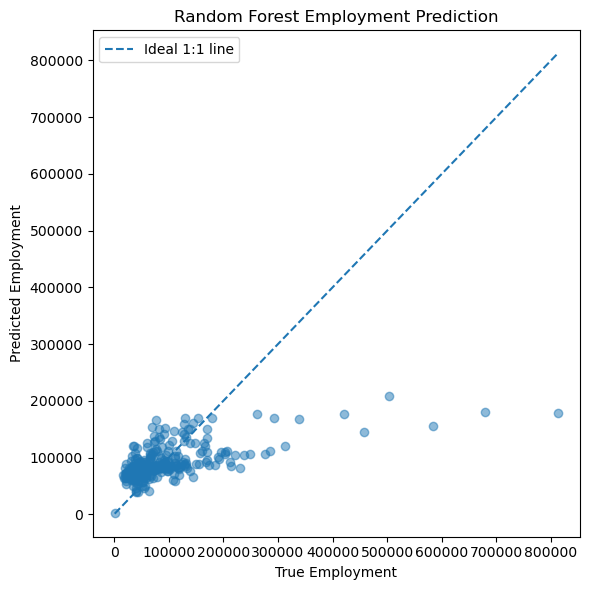

{'RMSE': 74833.23480311049,
 'MAE': 42704.7931605163,
 'R2': 0.29190092521639455,
 'MAPE': 61.31710602680877}

In [18]:
import numpy as np
import pandas as pd

true_col = "true_employment"
pred_col = "predicted_employment"

dfm = df_eval_summary[[true_col, pred_col]].copy()
for c in (true_col, pred_col):
    dfm[c] = pd.to_numeric(dfm[c], errors="coerce")
dfm = dfm.replace([np.inf, -np.inf], np.nan).dropna(subset=[true_col, pred_col])

y_true = dfm[true_col].to_numpy(float)
y_pred = dfm[pred_col].to_numpy(float)

# 2) 定义并调用评估函数（带 plt.show()）
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

def evaluate_model(y_true, y_pred, title="Random Forest Employment Prediction", save_path=None):
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]; y_pred = y_pred[mask]

    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"✅ RMSE : {rmse:,.2f} jobs")
    print(f"✅ MAE  : {mae:,.2f} jobs")
    print(f"✅ R²   : {r2:.3f}")
    print(f"✅ MAPE : {mape:.2f}%")

    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, "--", label="Ideal 1:1 line")
    plt.xlabel("True Employment"); plt.ylabel("Predicted Employment")
    plt.title(title); plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"📁 Figure saved to: {save_path}")
    plt.show()

    return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE": mape}

metrics = evaluate_model(y_true, y_pred, save_path="rf_eval.png")
metrics  
